<a href="https://colab.research.google.com/github/tsitsvero/rotor-gp/blob/main/pack/train_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [18]:
!pip install git+https://github.com/lab-cosmo/librascal gpytorch pytorch-lightning wandb git+https://github.com/chem-gp/fande xtb nbstripout
! nbstripout --install --global

  Cloning https://github.com/lab-cosmo/librascal to /tmp/pip-req-build-ufpjb1v8
  Running command git clone --filter=blob:none --quiet https://github.com/lab-cosmo/librascal /tmp/pip-req-build-ufpjb1v8
  Resolved https://github.com/lab-cosmo/librascal to commit 6c55e99720f9a181f1efc5c7cd4976c87809d79b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/chem-gp/fande to /tmp/pip-req-build-heot65o9
  Running command git clone --filter=blob:none --quiet https://github.com/chem-gp/fande /tmp/pip-req-build-heot65o9
  Resolved https://github.com/chem-gp/fande to commit 353b1733424bfdd15a117ac41dd5f909ed5ce40c
  Preparing metadata (setup.py) ... done


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!wget https://raw.githubusercontent.com/tsitsvero/rotor-gp/main/pack/cook_model.py

--2023-12-31 14:32:33--  https://raw.githubusercontent.com/tsitsvero/rotor-gp/main/pack/cook_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9070 (8.9K) [text/plain]
Saving to: ‘cook_model.py.1’

cook_model.py.1     100%[===================>]   8.86K  --.-KB/s    in 0s      

2023-12-31 14:32:33 (75.3 MB/s) - ‘cook_model.py.1’ saved [9070/9070]



## Cooking up the model

In [21]:
# Prepare the training data:

from ase import io
import os

# DATA_DIR = os.path.expanduser("~/repos/data/")
# # DATA_DIR = "/data1/simulations/datasets/rotors/high_temp_ML_training_data/"
# RESULTS_DIR = os.path.expanduser("~/repos/data/results")

DATA_DIR = os.path.expanduser("/content/drive/MyDrive/data/")
# FANDE_DIR = os.path.expanduser("~/")
RESULTS_DIR = os.path.expanduser("/content/drive/MyDrive/data/results/")
os.makedirs(RESULTS_DIR, exist_ok=True)

PREPARE_DATA = False
if PREPARE_DATA:
        traj_295 = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index=":")
        # traj_355 = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_355_355K/md_trajectory.traj", index=":")
        traj_295_2000K = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_295_2000K/md_trajectory.traj", index=":")
        # traj_355_2000K = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_355_2000K/md_trajectory.traj", index=":")
        # traj_295_2000K_forced = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_295_2000K_0075force/md_trajectory.traj", index=":")
        # traj_355_2000K_forced = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_355_2000K_0075force/md_trajectory.traj", index=":")

        # trajectory_energy = traj_295[0:5000] + traj_355[0:5000] + traj_295_2000K[0:5000] + traj_355_2000K[0:5000] + traj_295_2000K_forced[0:5000] + traj_355_2000K_forced[0:5000]

        train_energy = traj_295[0:5000:10] +  traj_295_2000K[0:5000:10]
        train_forces = traj_295_2000K[0:5000:5]
        validation_energy = traj_295[1000:1010]
        validation_forces = traj_295[1000:1010]

        io.write(DATA_DIR+"/train_energy.traj", train_energy)
        io.write(DATA_DIR+"/train_forces.traj", train_forces)
        io.write(DATA_DIR+"/validation_energy.traj", validation_energy)
        io.write(DATA_DIR+"/validation_forces.traj", validation_forces)


In [22]:
%%time
# ENERGY_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
# ENERGY_NUM_INDUCING_POINTS = 10
# ENERGY_LR = 0.1
# ENERGY_NUM_STEPS = 5

# FORCES_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
# FORCES_NUM_INDUCING_POINTS = 10
# NUM_FORCE_SAMPLES = 10
# FORCES_LR = 0.1
# FORCES_NUM_STEPS = 5

# PREDICTOR_NAME = 'test.pth'
# SUBSAMPLE = 200 # subsample data to reduce time durings tests


ENERGY_MODEL = 'exact' #'variational_inducing_points', 'exact'
ENERGY_NUM_INDUCING_POINTS = 500
ENERGY_LR = 0.01
ENERGY_NUM_STEPS = 2000

FORCES_MODEL = 'exact' #'variational_inducing_points', 'exact'
FORCES_NUM_INDUCING_POINTS = 500
NUM_FORCE_SAMPLES = 1000
FORCES_LR = 0.01
FORCES_NUM_STEPS = 2000

PREDICTOR_NAME = 'exact.pth'
SUBSAMPLE = 2 # subsample data to reduce time durings tests

! python cook_model.py \
--data_dir $DATA_DIR \
--results_dir $RESULTS_DIR \
--energy_model $ENERGY_MODEL \
--energy_num_inducing_points $ENERGY_NUM_INDUCING_POINTS \
--energy_lr $ENERGY_LR \
--energy_num_steps $ENERGY_NUM_STEPS \
--forces_model $FORCES_MODEL \
--forces_num_inducing_points $FORCES_NUM_INDUCING_POINTS \
--num_force_samples $NUM_FORCE_SAMPLES \
--forces_lr $FORCES_LR \
--forces_num_steps $FORCES_NUM_STEPS \
--predictor_name $PREDICTOR_NAME \
--subsample $SUBSAMPLE


DATA_DIR /content/drive/MyDrive/data/
RESULTS_DIR /content/drive/MyDrive/data/results/
ENERGY_MODEL exact
ENERGY_NUM_INDUCING_POINTS 500
ENERGY_LR 0.01
ENERGY_NUM_STEPS 2000
FORCES_MODEL exact
FORCES_NUM_INDUCING_POINTS 500
NUM_FORCE_SAMPLES 1000
FORCES_LR 0.01
FORCES_NUM_STEPS 2000
PREDICTOR_NAME exact.pth
500 500
fande.models module imported...
Icecream logger is not available
Total number of found groups: 14
Checking if all atoms are covered:  True
Preparing dataloaders...
Total length of traj is 500
Total number of batches 500
Calculating invariants on trajectory with librascal...
100% 500/500 [00:21<00:00, 23.33it/s]
invariants for energy fitting calculated
100% 500/500 [13:25<00:00,  1.61s/it]
invariants for forces fitting calculated
torch.Size([500, 1200])
torch.Size([500])
Dataloader for group 0 created
Number of samples in dataloader: 1000
Dataloader for group 1 created
Number of samples in dataloader: 1000
Dataloader for group 2 created
Number of samples in dataloader: 1000
D

In [23]:
%%time
ENERGY_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
ENERGY_NUM_INDUCING_POINTS = 500
ENERGY_LR = 0.01
ENERGY_NUM_STEPS = 2000

FORCES_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
FORCES_NUM_INDUCING_POINTS = 500
NUM_FORCE_SAMPLES = 1000
FORCES_LR = 0.01
FORCES_NUM_STEPS = 2000

PREDICTOR_NAME = 'inducing.pth'
SUBSAMPLE = 2 # subsample data to reduce time durings tests

! python cook_model.py \
--data_dir $DATA_DIR \
--results_dir $RESULTS_DIR \
--energy_model $ENERGY_MODEL \
--energy_num_inducing_points $ENERGY_NUM_INDUCING_POINTS \
--energy_lr $ENERGY_LR \
--energy_num_steps $ENERGY_NUM_STEPS \
--forces_model $FORCES_MODEL \
--forces_num_inducing_points $FORCES_NUM_INDUCING_POINTS \
--num_force_samples $NUM_FORCE_SAMPLES \
--forces_lr $FORCES_LR \
--forces_num_steps $FORCES_NUM_STEPS \
--predictor_name $PREDICTOR_NAME \
--subsample $SUBSAMPLE

DATA_DIR /content/drive/MyDrive/data/
RESULTS_DIR /content/drive/MyDrive/data/results/
ENERGY_MODEL variational_inducing_points
ENERGY_NUM_INDUCING_POINTS 500
ENERGY_LR 0.01
ENERGY_NUM_STEPS 2000
FORCES_MODEL variational_inducing_points
FORCES_NUM_INDUCING_POINTS 500
NUM_FORCE_SAMPLES 1000
FORCES_LR 0.01
FORCES_NUM_STEPS 2000
PREDICTOR_NAME inducing.pth
500 500
fande.models module imported...
Icecream logger is not available
Total number of found groups: 14
Checking if all atoms are covered:  True
Preparing dataloaders...
Total length of traj is 500
Total number of batches 500
Calculating invariants on trajectory with librascal...
100% 500/500 [00:23<00:00, 21.63it/s]
invariants for energy fitting calculated
100% 500/500 [13:33<00:00,  1.63s/it]
invariants for forces fitting calculated
torch.Size([500, 1200])
torch.Size([500])
Dataloader for group 0 created
Number of samples in dataloader: 1000
Dataloader for group 1 created
Number of samples in dataloader: 1000
Dataloader for group 2 

## Testing models

In [24]:
from ase import io
test_traj = io.read(DATA_DIR + "/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index="1000:1010")

In [28]:
import sys
import torch
FANDE_DIR = os.path.expanduser("~/repos/")
sys.path.append(FANDE_DIR + "fande/")

from fande.predict import FandePredictor
from fande.ase import FandeCalc
# load the predictor:
# predictor_loaded = torch.load(RESULTS_DIR + "/fande_predictor.pth")
predictor_loaded = torch.load(RESULTS_DIR + "/inducing.pth")
fande_calc_loaded = FandeCalc(predictor_loaded)
device = torch.device('cpu')
fande_calc_loaded.predictor.move_models_to_device(device)

In [29]:
forces_true = []
forces_predicted = []

energy_true = []
energy_predicted = []

for atoms in test_traj:
    forces_true.append(atoms.get_forces())
    energy_true.append(atoms.get_potential_energy())
    atoms.set_calculator(fande_calc_loaded)
    forces_predicted.append(atoms.get_forces())
    energy_predicted.append(atoms.get_potential_energy())

INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  2516.345262527466
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.22792816162109375
Time prediction:  16.245365142822266
Time moving on device:  0.3342628479003906
Time total:  18.581628799438477
Time for invariants (call from forces):  1704.0982246398926
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.21696090698242188
Time prediction:  58.387041091918945
Time moving on device:  1.6283988952636719
Time total:  61.44547462463379
Time for invariants (call from forces):  1717.9298400878906
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.20551681518554688
Time prediction:  49.59416389465332
Time moving on device:  0.30541419982910156
Time total:  67.70682334899902
Time for invariants (call from forces):  1696.143627166748
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.19788742065429688
Time prediction:  111.91058158874512
Time moving on device:  1.2950897216796875
Time total:  121.1395263671875


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1688.1000995635986
Predicting forces...
Energy model summary: 
Time invariants:  0.21147727966308594
Time prediction:  4.313230514526367
Time moving on device:  0.25653839111328125
Time total:  12.748479843139648
Time for invariants (call from forces):  1655.3504467010498
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.2262592315673828
Time prediction:  20.823955535888672
Time moving on device:  1.1873245239257812
Time total:  23.73647689819336
Time for invariants (call from forces):  1903.0523300170898
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.21266937255859375
Time prediction:  101.77135467529297
Time moving on device:  0.3337860107421875
Time total:  114.51029777526855
Time for invariants (call from forces):  1721.557378768921
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.17976760864257812
Time prediction:  92.45061874389648
Time moving on device:  2.0008087158203125
Time total:  125.44965744018555


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1741.1525249481201
Predicting forces...
Energy model summary: 
Time invariants:  0.2300739288330078
Time prediction:  28.80549430847168
Time moving on device:  0.29277801513671875
Time total:  37.05167770385742
Time for invariants (call from forces):  1639.9023532867432
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.24271011352539062
Time prediction:  18.71180534362793
Time moving on device:  6.537675857543945
Time total:  26.77154541015625
Time for invariants (call from forces):  1887.9411220550537
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.24843215942382812
Time prediction:  100.78835487365723
Time moving on device:  0.4017353057861328
Time total:  109.25912857055664


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1854.707956314087
Predicting forces...
Energy model summary: 
Time invariants:  0.1895427703857422
Time prediction:  8.331298828125
Time moving on device:  1.0693073272705078
Time total:  16.259193420410156


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1752.9499530792236
Predicting forces...
Energy model summary: 
Time invariants:  0.23937225341796875
Time prediction:  25.01678466796875
Time moving on device:  0.392913818359375
Time total:  30.879497528076172
Time for invariants (call from forces):  1791.9180393218994
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.19216537475585938
Time prediction:  108.88338088989258
Time moving on device:  0.8900165557861328
Time total:  128.65877151489258


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1672.0106601715088
Predicting forces...
Energy model summary: 
Time invariants:  0.21958351135253906
Time prediction:  3.7152767181396484
Time moving on device:  0.2694129943847656
Time total:  5.475521087646484
Time for invariants (call from forces):  1743.4144020080566
Predicting forces...
Energy model summary: 
Time invariants:  0.21266937255859375
Time prediction:  20.65563201904297
Time moving on device:  10.15925407409668
Time total:  38.881778717041016


INFO:fande:Setting context for descriptors calculation to production
INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1709.369421005249
Predicting forces...
Energy model summary: 
Time invariants:  0.179290771484375
Time prediction:  4.288911819458008
Time moving on device:  0.29087066650390625
Time total:  12.606382369995117


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1621.034860610962
Predicting forces...
Energy model summary: 
Time invariants:  0.2205371856689453
Time prediction:  21.03877067565918
Time moving on device:  9.911060333251953
Time total:  39.090871810913086


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1721.6062545776367
Predicting forces...
Energy model summary: 
Time invariants:  0.19478797912597656
Time prediction:  14.042139053344727
Time moving on device:  0.3590583801269531
Time total:  22.502660751342773
Time for invariants (call from forces):  1603.8358211517334
Predicting forces...
Energy model summary: 
Time invariants:  0.2562999725341797
Time prediction:  19.92964744567871
Time moving on device:  1.1000633239746094
Time total:  22.517919540405273


Atomic group [0, 1, 2, 3, 4, 5, 264, 265, 266, 267, 268, 269]
F_x
MAE 0.19503087420016527
RMSE 0.24011489987615145
F_y
MAE 0.3155219313999017
RMSE 0.39487762592406694
F_z
MAE 0.23146961852908135
RMSE 0.29479298552932925
E
MAE 0.3227295
RMSE 0.33698848


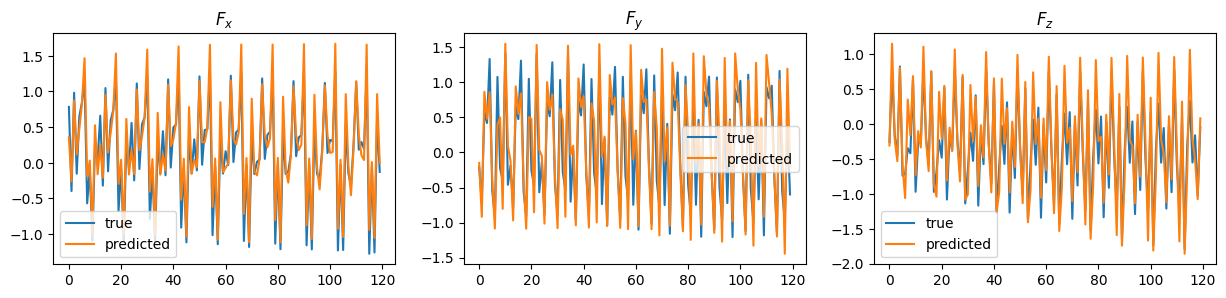

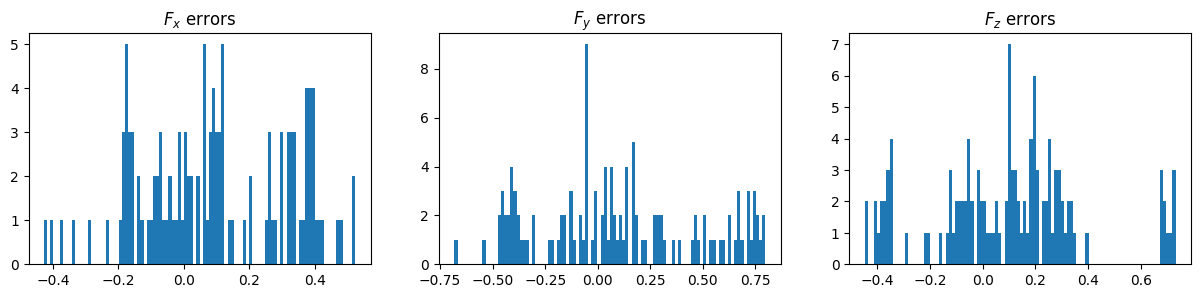

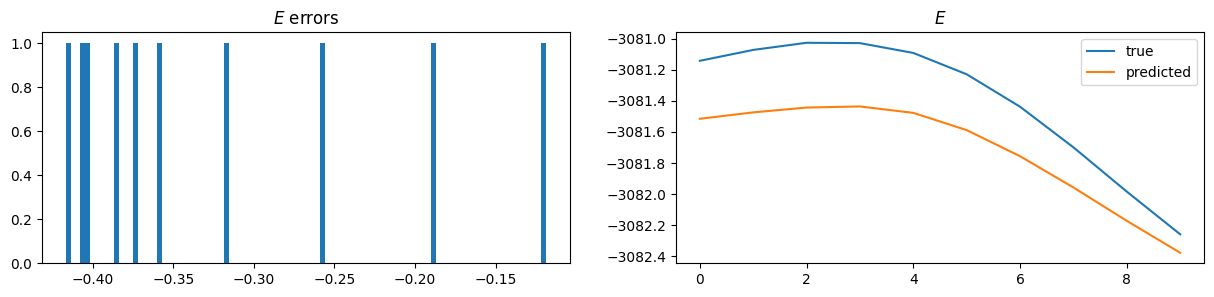

Atomic group [146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 5

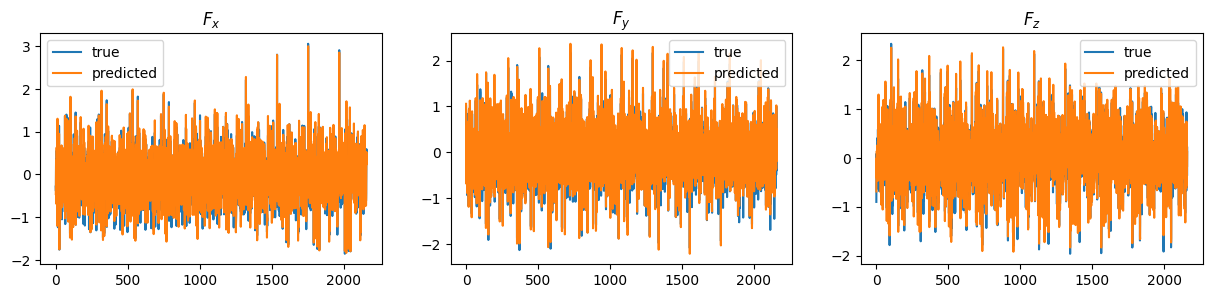

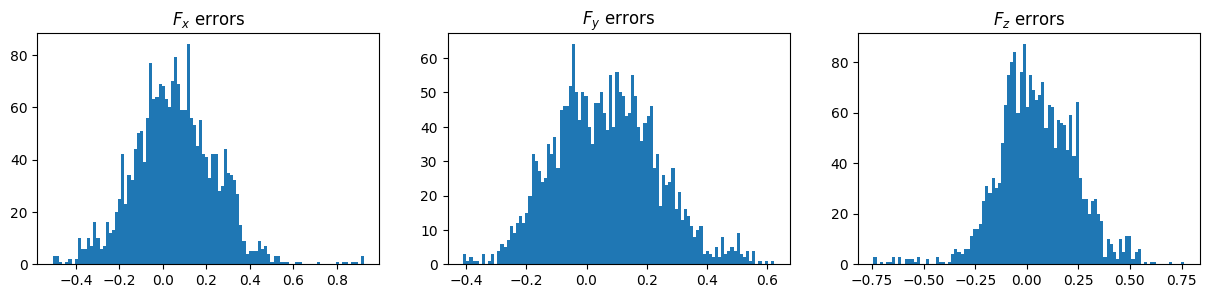

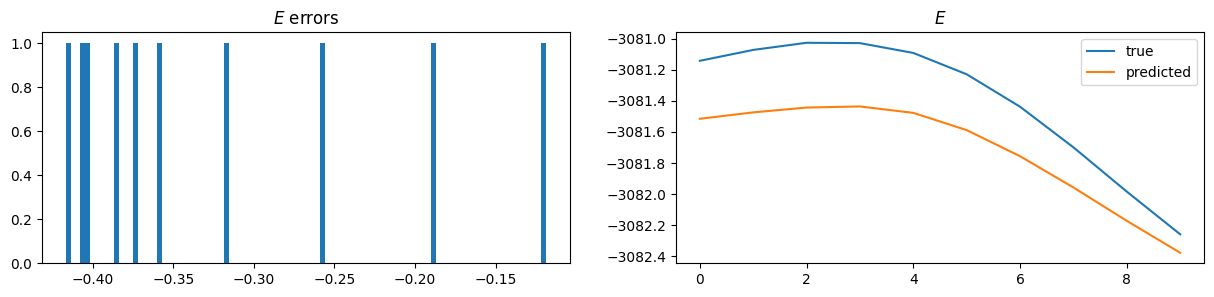

Atomic group [56, 57, 58, 59, 60, 61, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 98, 99, 100, 101, 320, 321, 322, 323, 324, 325, 330, 331, 332, 333, 334, 335, 336, 337, 340, 341, 342, 343, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 362, 363, 364, 365]
F_x
MAE 0.34583693659450443
RMSE 0.4209594889100186
F_y
MAE 0.27382328883848256
RMSE 0.34593531266906496
F_z
MAE 0.2398345152899209
RMSE 0.3109211170610049
E
MAE 0.3227295
RMSE 0.33698848


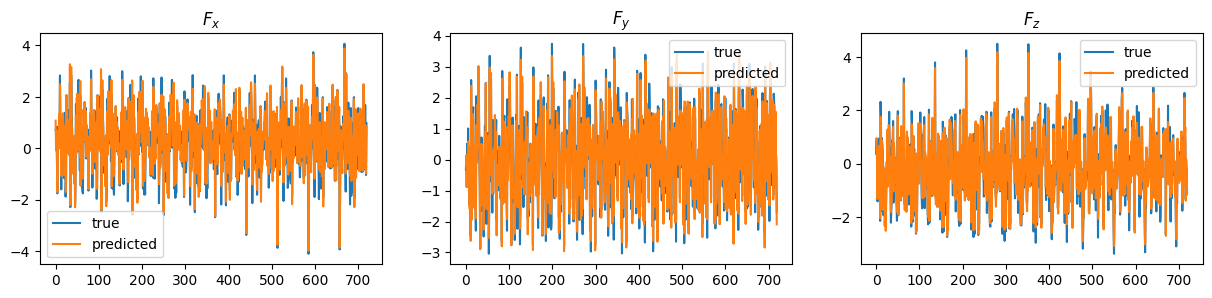

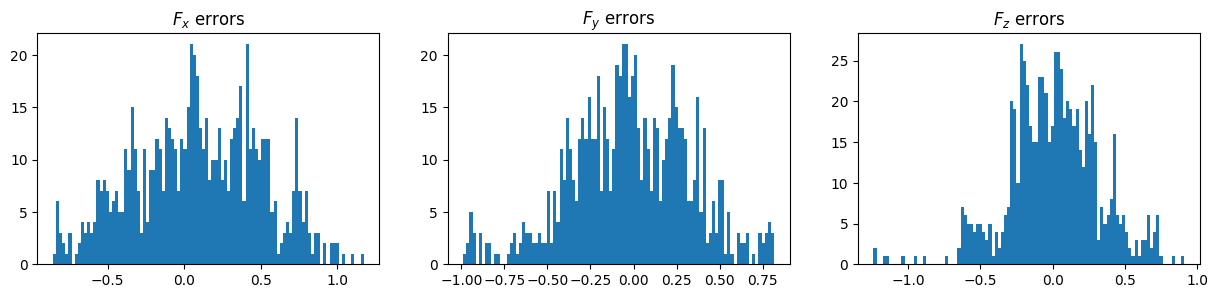

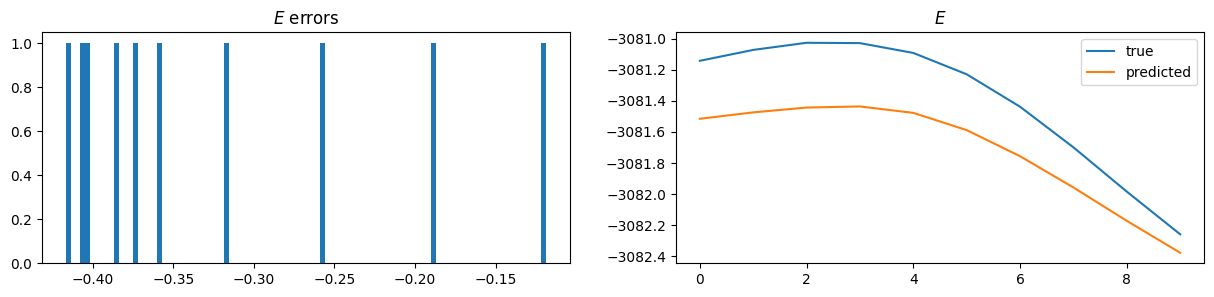

Atomic group [108, 109, 110, 111, 112, 113, 372, 373, 374, 375, 376, 377]
F_x
MAE 0.20333851370960473
RMSE 0.2523654374054026
F_y
MAE 0.19036620942254862
RMSE 0.22407018005635188
F_z
MAE 0.1560844994460543
RMSE 0.20802082348813195
E
MAE 0.3227295
RMSE 0.33698848


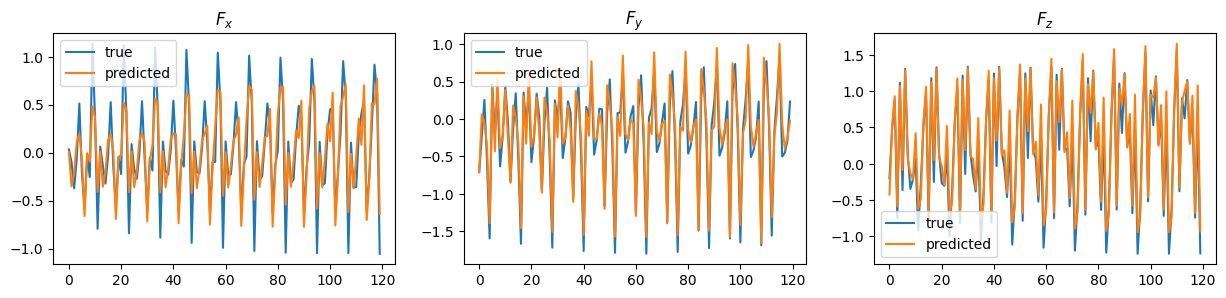

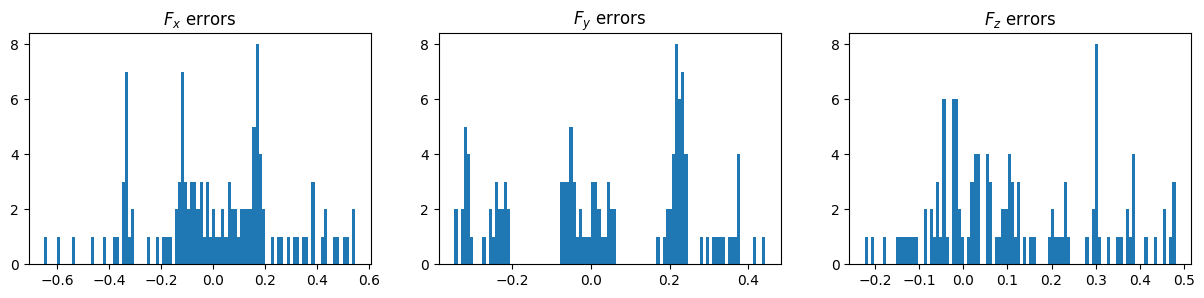

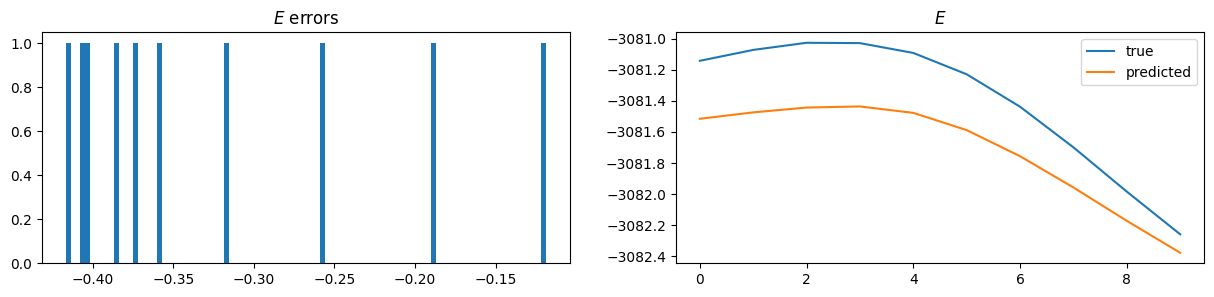

Atomic group [6, 7, 8, 9, 10, 11, 270, 271, 272, 273, 274, 275]
F_x
MAE 0.25471086489657563
RMSE 0.308949655148483
F_y
MAE 0.18907329527040323
RMSE 0.2279530773346461
F_z
MAE 0.2151961263269186
RMSE 0.2544814209846005
E
MAE 0.3227295
RMSE 0.33698848


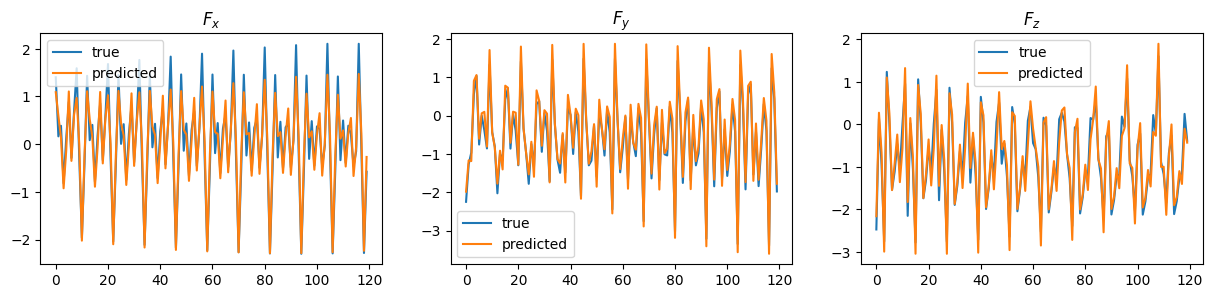

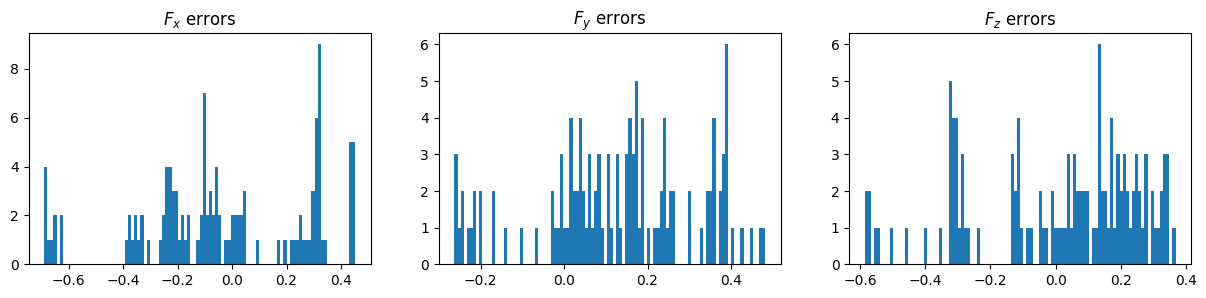

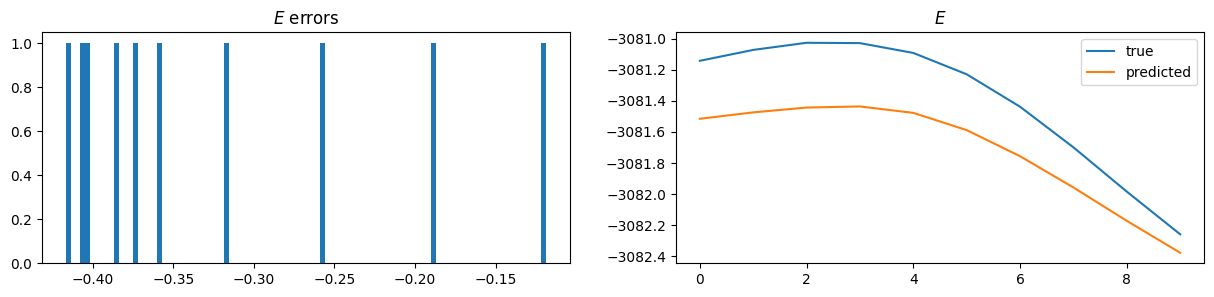

Atomic group [116, 117, 118, 119, 122, 123, 124, 125, 134, 135, 136, 137, 380, 381, 382, 383, 386, 387, 388, 389, 398, 399, 400, 401]
F_x
MAE 0.11598950919384758
RMSE 0.15063180932126147
F_y
MAE 0.12620691553068658
RMSE 0.1651227180700334
F_z
MAE 0.12888190581773717
RMSE 0.16325144383457585
E
MAE 0.3227295
RMSE 0.33698848


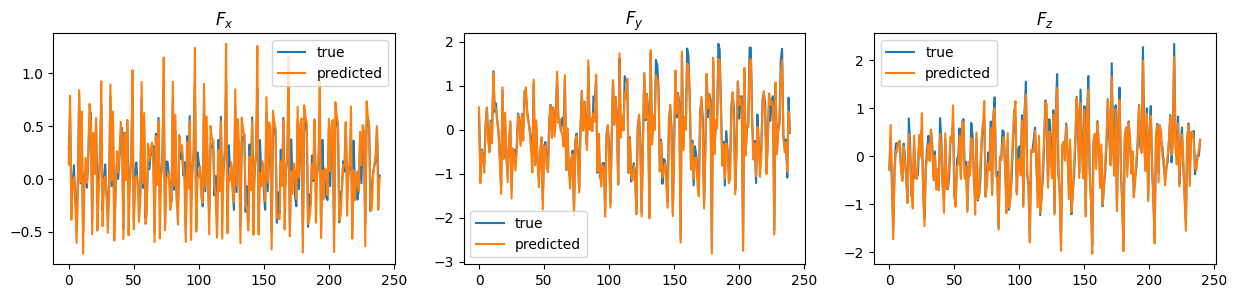

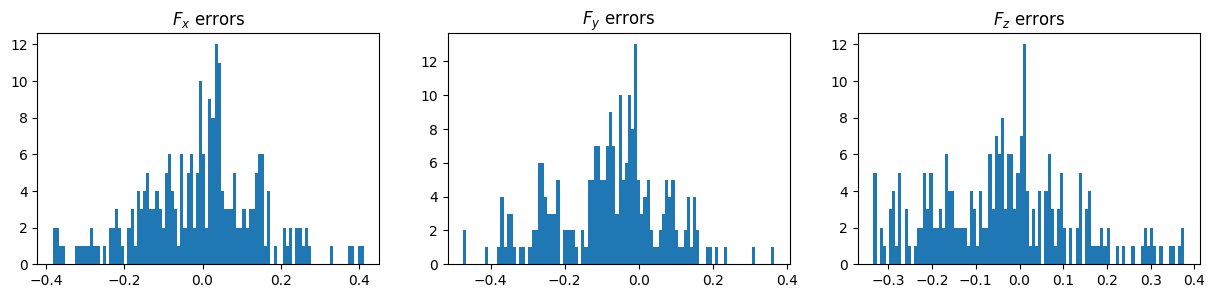

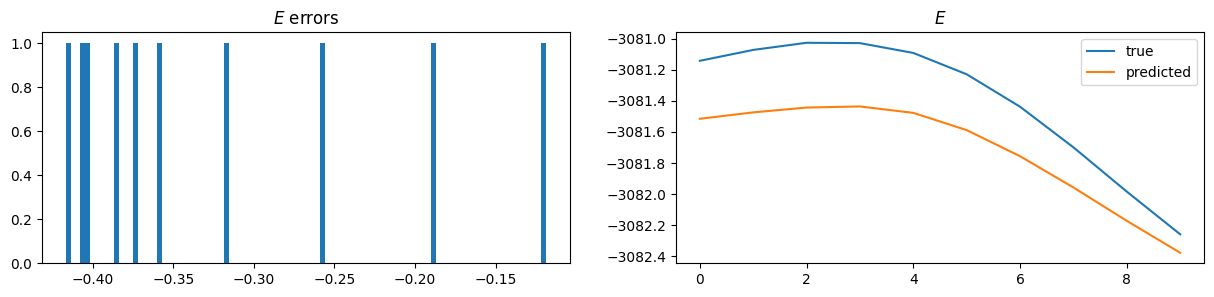

Atomic group [36, 37, 50, 51, 52, 53, 54, 55, 62, 63, 64, 65, 74, 75, 80, 81, 96, 97, 300, 301, 314, 315, 316, 317, 318, 319, 326, 327, 328, 329, 338, 339, 344, 345, 360, 361]
F_x
MAE 0.2918867645992173
RMSE 0.3638285539408563
F_y
MAE 0.27945108637213706
RMSE 0.3536333957620192
F_z
MAE 0.2270622343238857
RMSE 0.2888789033374724
E
MAE 0.3227295
RMSE 0.33698848


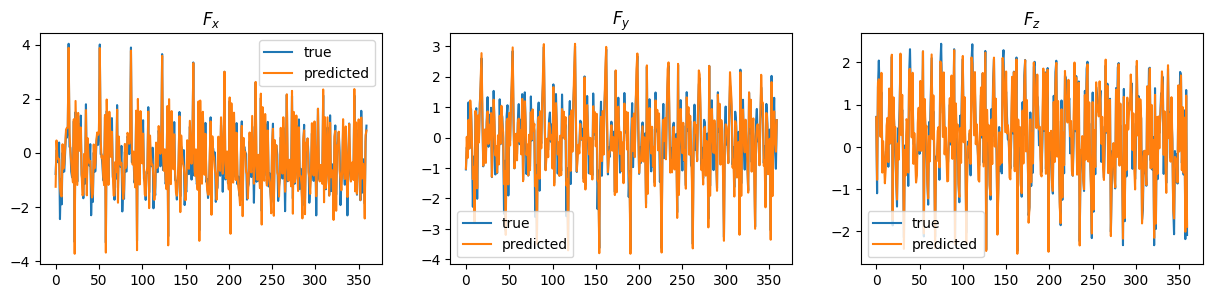

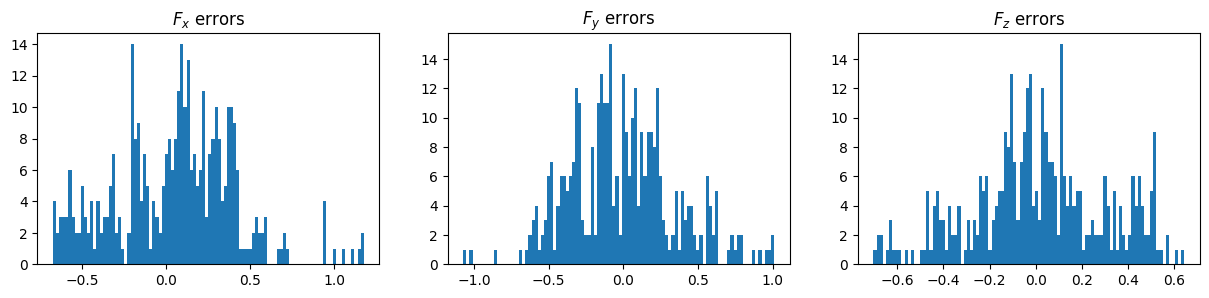

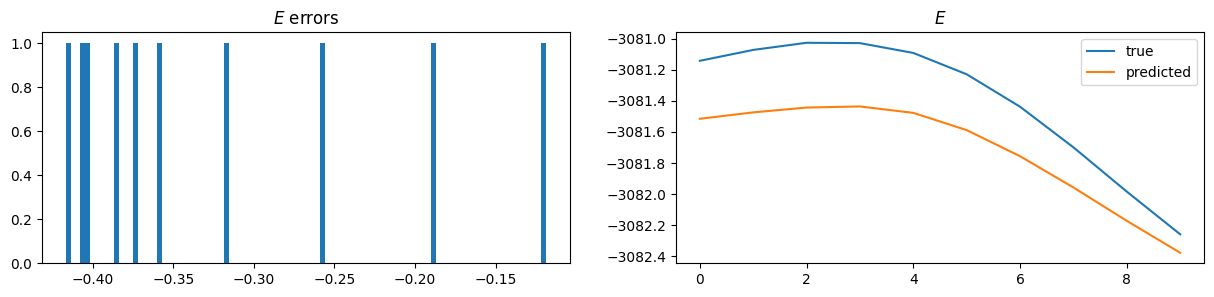

Atomic group [114, 115, 120, 121, 126, 127, 128, 129, 132, 133, 138, 139, 378, 379, 384, 385, 390, 391, 392, 393, 396, 397, 402, 403]
F_x
MAE 0.12642276264571894
RMSE 0.1681380448874457
F_y
MAE 0.07245706170797347
RMSE 0.08883704631223456
F_z
MAE 0.11715527103903393
RMSE 0.1445510196262608
E
MAE 0.3227295
RMSE 0.33698848


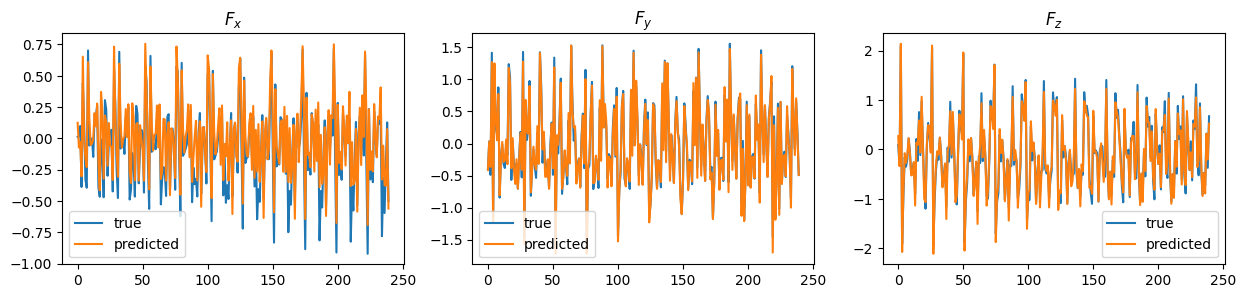

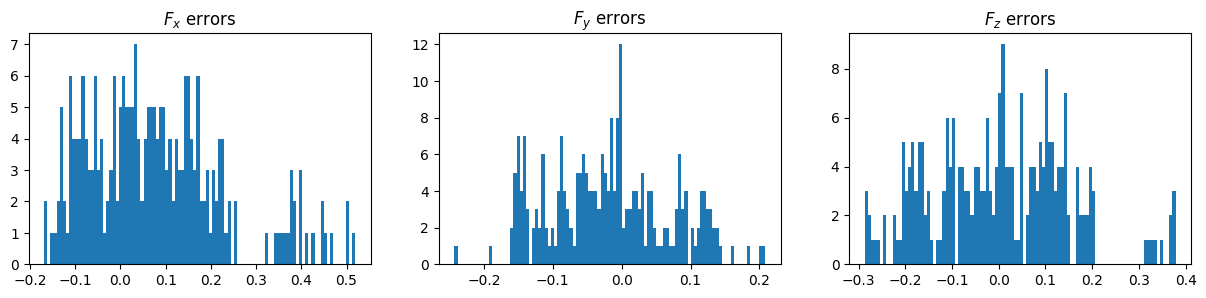

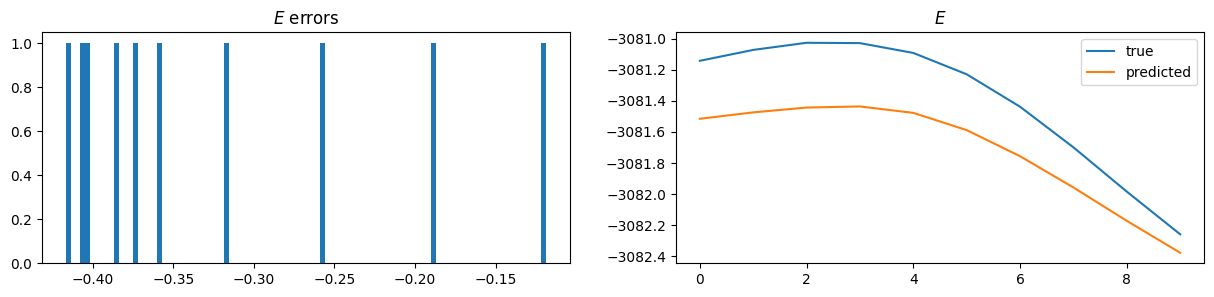

Atomic group [16, 17, 20, 21, 24, 25, 28, 29, 42, 43, 46, 47, 280, 281, 284, 285, 288, 289, 292, 293, 306, 307, 310, 311]
F_x
MAE 0.16960200369358064
RMSE 0.21881008526075071
F_y
MAE 0.28395501418660085
RMSE 0.352177933354387
F_z
MAE 0.28022307019370296
RMSE 0.3295211855369478
E
MAE 0.3227295
RMSE 0.33698848


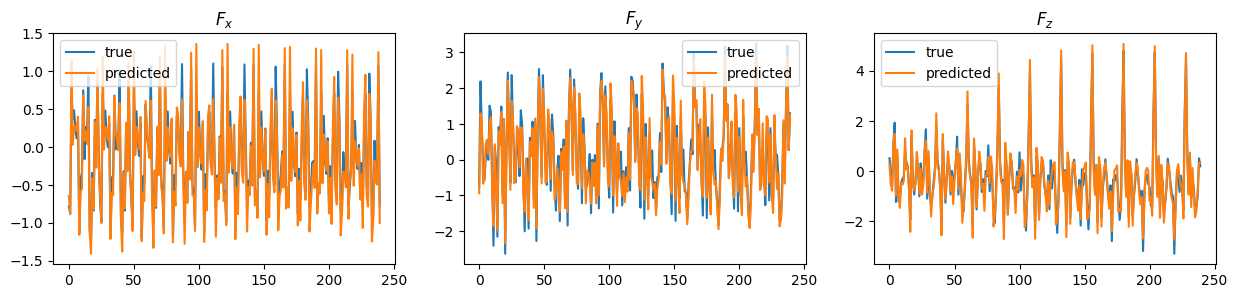

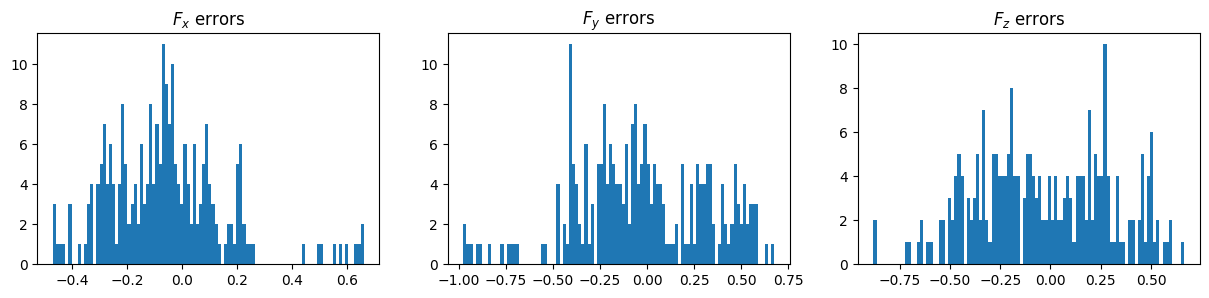

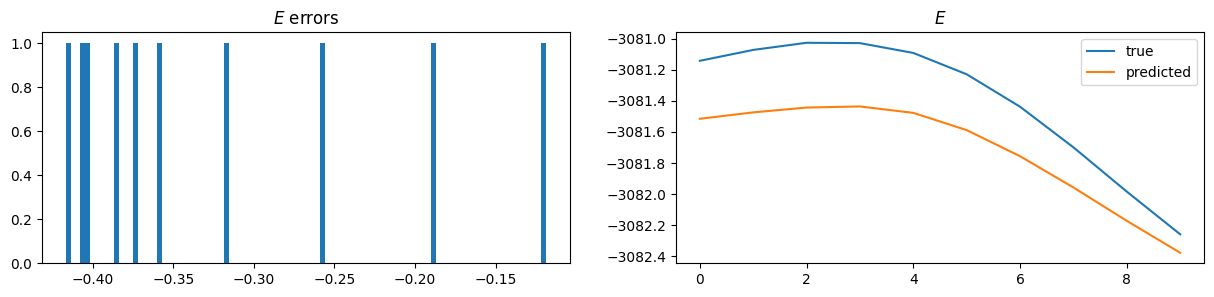

Atomic group [130, 131, 140, 141, 142, 143, 144, 145, 164, 165, 166, 167, 192, 193, 206, 207, 250, 251, 394, 395, 404, 405, 406, 407, 408, 409, 428, 429, 430, 431, 456, 457, 470, 471, 514, 515]
F_x
MAE 0.10514244331150419
RMSE 0.13649599430978085
F_y
MAE 0.11761184156768852
RMSE 0.1424586415420666
F_z
MAE 0.12402028808784153
RMSE 0.15979740293611538
E
MAE 0.3227295
RMSE 0.33698848


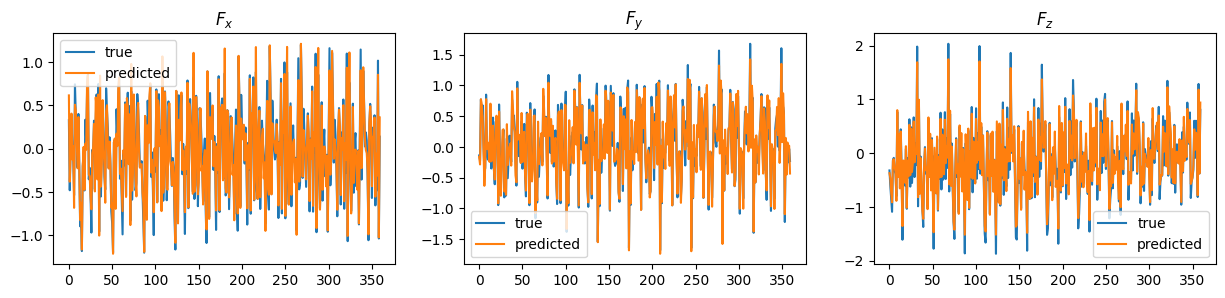

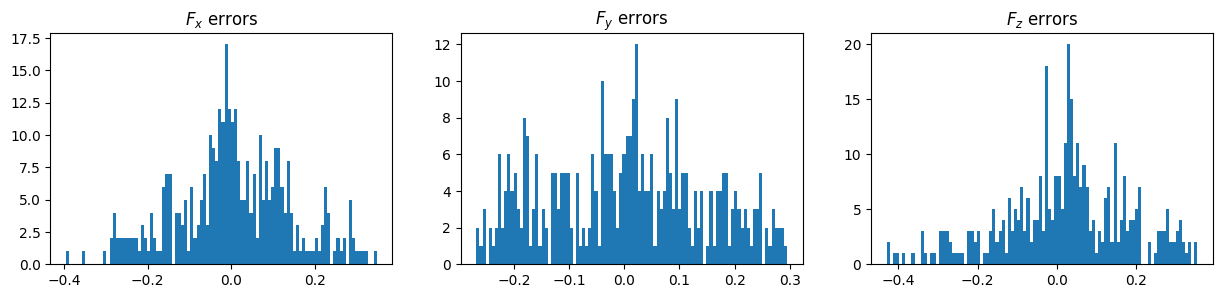

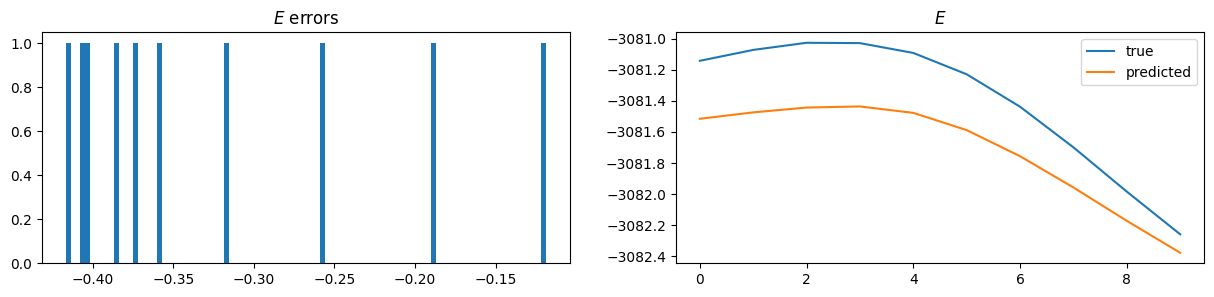

Atomic group [18, 19, 26, 27, 44, 45, 282, 283, 290, 291, 308, 309]
F_x
MAE 0.1883096187065045
RMSE 0.26733717944373414
F_y
MAE 0.19087493286157647
RMSE 0.23023243796535067
F_z
MAE 0.14913798753793042
RMSE 0.17386846083580015
E
MAE 0.3227295
RMSE 0.33698848


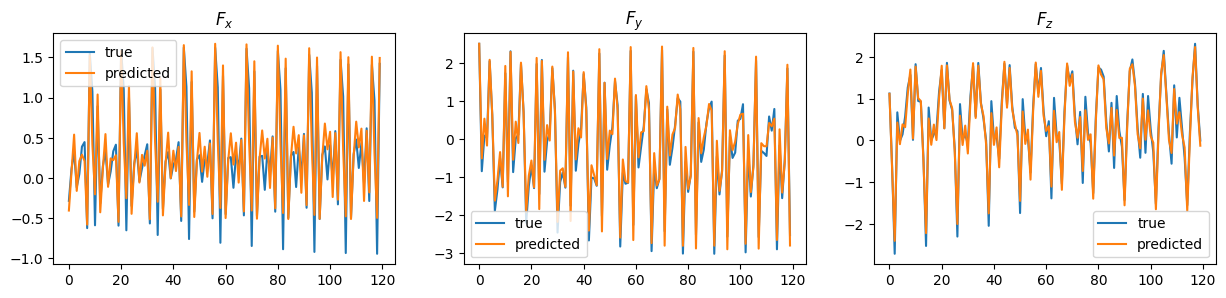

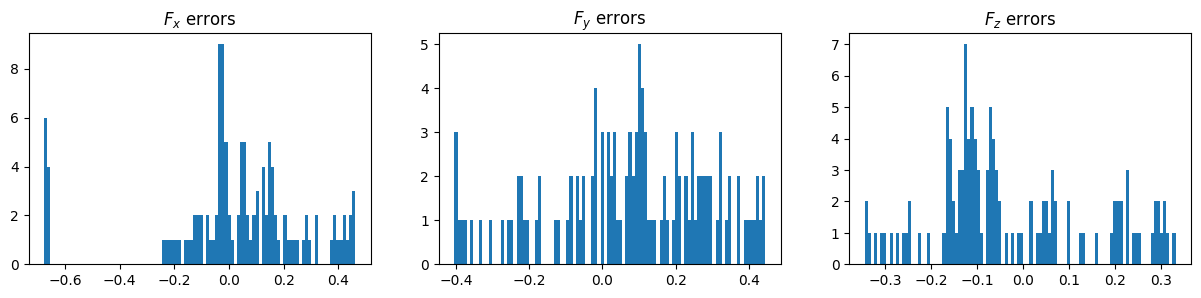

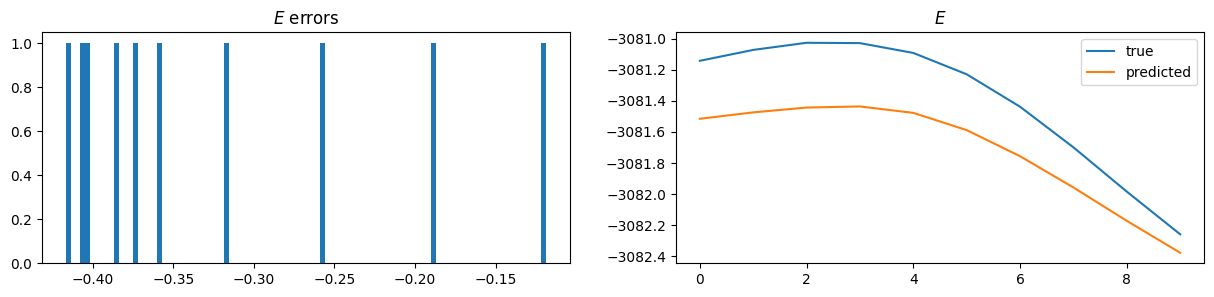

Atomic group [14, 15, 22, 23, 30, 31, 34, 35, 40, 41, 48, 49, 278, 279, 286, 287, 294, 295, 298, 299, 304, 305, 312, 313]
F_x
MAE 0.14081494842345516
RMSE 0.1811359218223735
F_y
MAE 0.22603085807835063
RMSE 0.28475662958877823
F_z
MAE 0.2590422763178746
RMSE 0.3125264827084523
E
MAE 0.3227295
RMSE 0.33698848


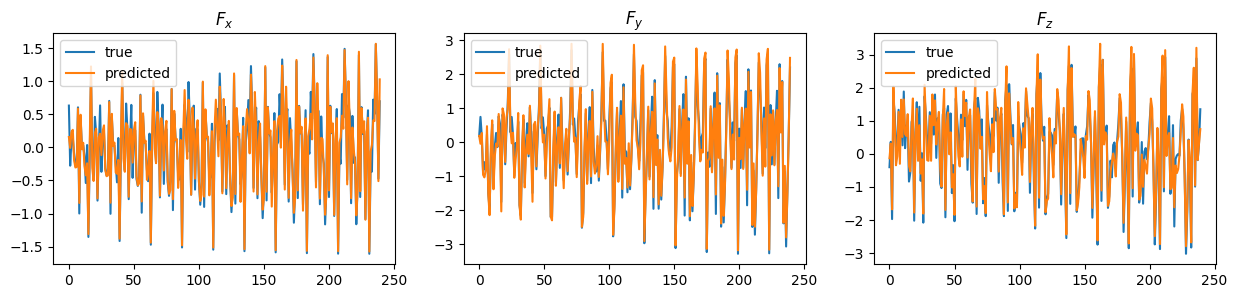

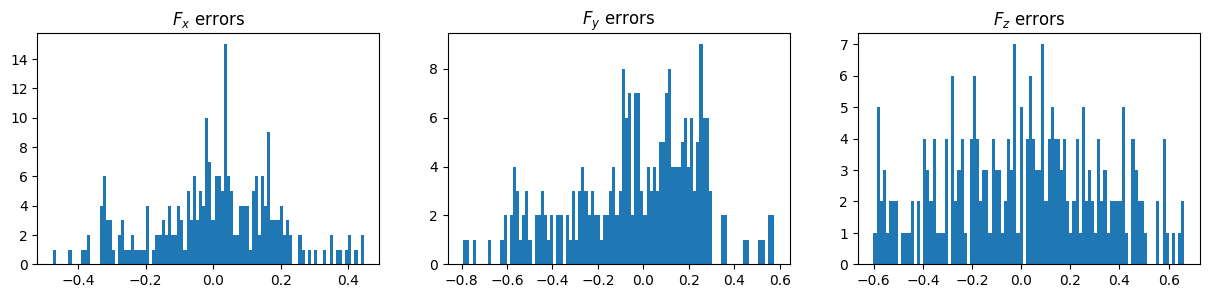

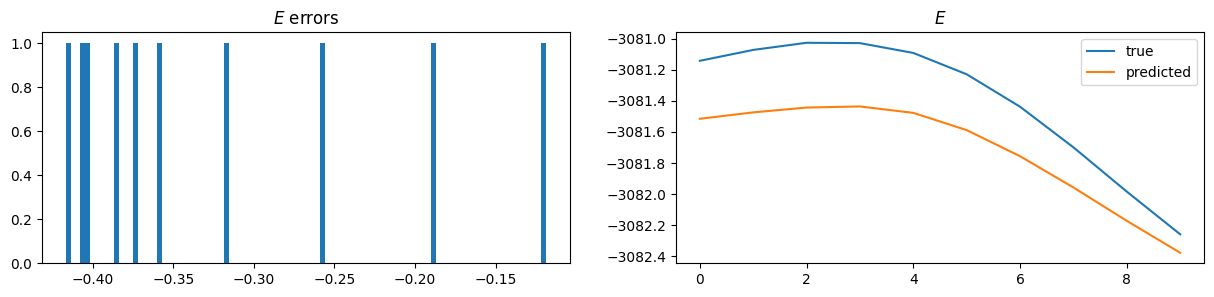

Atomic group [12, 13, 32, 33, 38, 39, 276, 277, 296, 297, 302, 303]
F_x
MAE 0.1924115477129817
RMSE 0.26251488050675803
F_y
MAE 0.17710363579293092
RMSE 0.23472368521740533
F_z
MAE 0.20162228451420863
RMSE 0.2526457482725669
E
MAE 0.3227295
RMSE 0.33698848


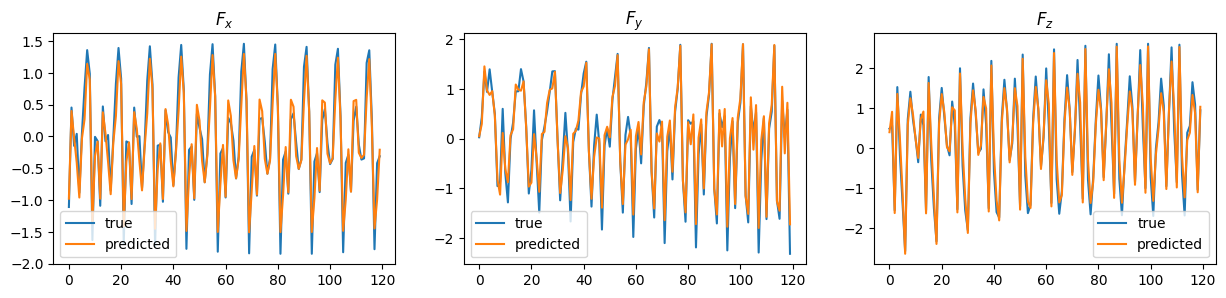

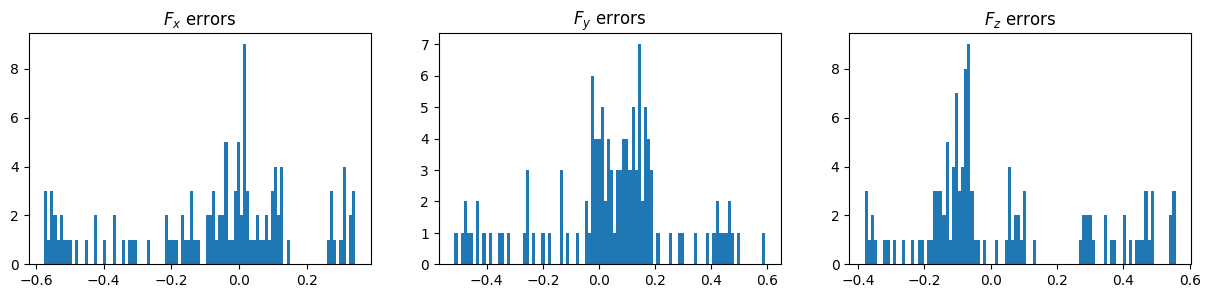

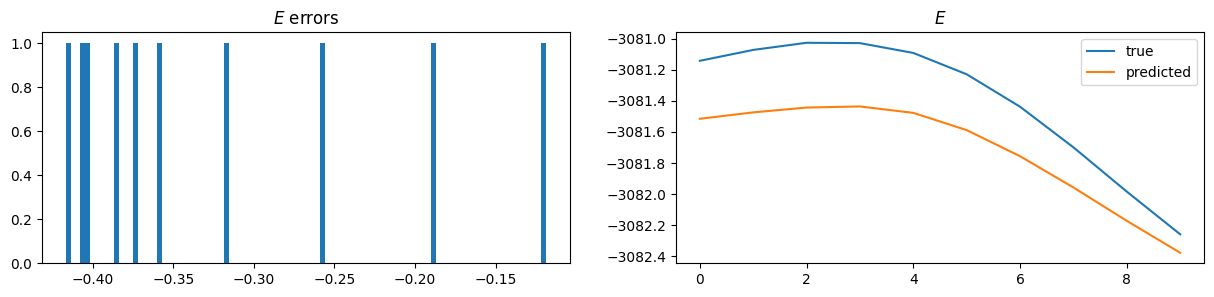

Atomic group [102, 103, 104, 105, 106, 107, 366, 367, 368, 369, 370, 371]
F_x
MAE 0.1904539382085204
RMSE 0.23514364068398505
F_y
MAE 0.1961586699510614
RMSE 0.2250539106407135
F_z
MAE 0.25408067405223844
RMSE 0.3146734067429486
E
MAE 0.3227295
RMSE 0.33698848


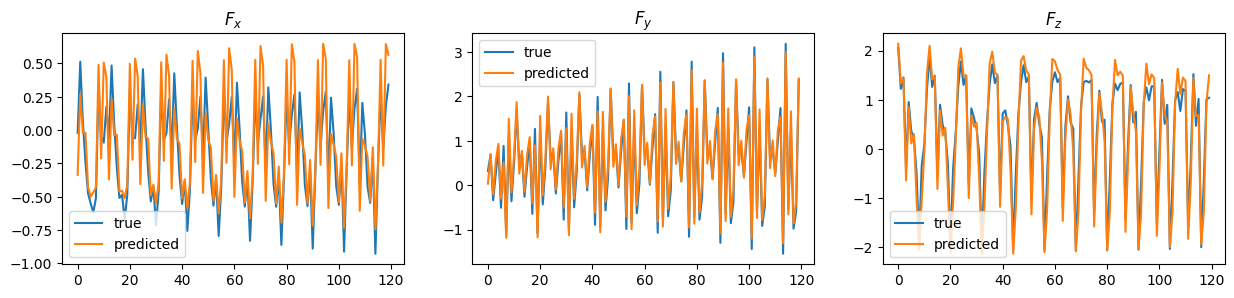

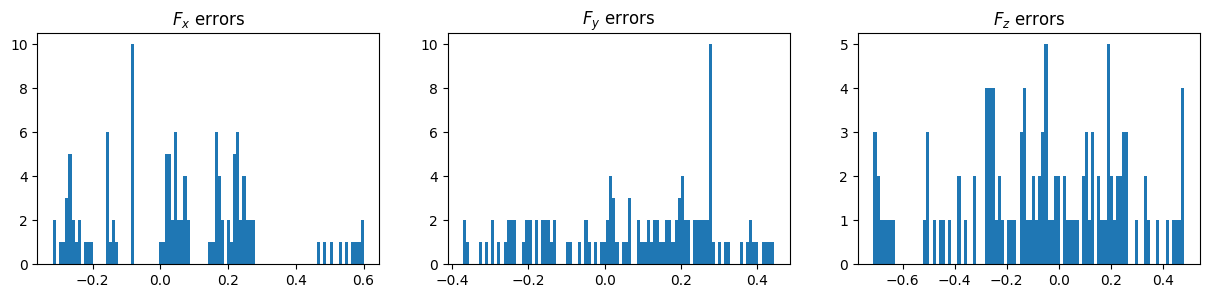

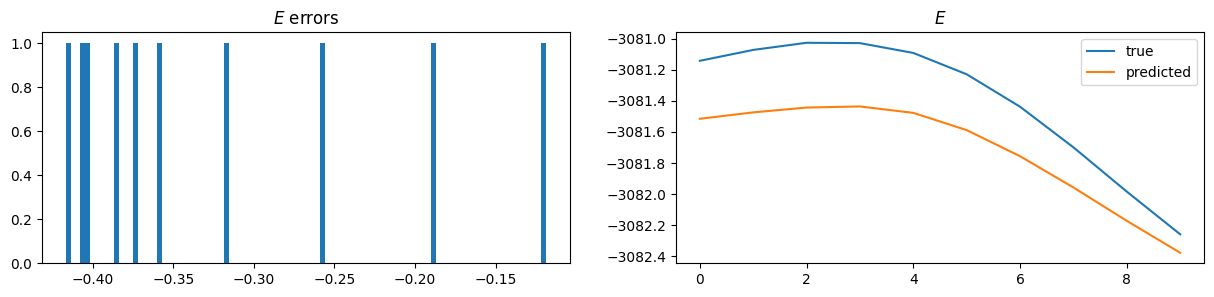

In [30]:
import numpy as np
import matplotlib.pyplot as plt

energy_true = np.array(energy_true)
energy_predicted = np.array(energy_predicted)
energy_errors = energy_predicted - energy_true

forces_true = np.array(forces_true)
forces_predicted = np.array(forces_predicted)
forces_errors = forces_predicted - forces_true

atomic_groups = predictor_loaded.fdm.atomic_groups



for ag in atomic_groups:

    print("Atomic group", ag)
    print("F_x")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 0].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 0].flatten()**2)))
    print("F_y")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 1].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 1].flatten()**2)))
    print("F_z")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 2].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 2].flatten()**2)))
    print("E")
    print("MAE", np.mean(np.abs(energy_errors.flatten())))
    print("RMSE", np.sqrt(np.mean(energy_errors.flatten()**2)))

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
    axs[0].set_title(r"$F_x$")
    axs[0].plot(np.array(forces_true)[:, ag, 0].flatten(), label="true")
    axs[0].plot(np.array(forces_predicted)[:, ag, 0].flatten(), label="predicted")
    axs[0].legend()

    axs[1].set_title(r"$F_y$")
    axs[1].plot(np.array(forces_true)[:, ag, 1].flatten(), label="true")
    axs[1].plot(np.array(forces_predicted)[:, ag, 1].flatten(), label="predicted")
    axs[1].legend()

    axs[2].set_title(r"$F_z$")
    axs[2].plot(np.array(forces_true)[:, ag, 2].flatten(), label="true")
    axs[2].plot(np.array(forces_predicted)[:, ag, 2].flatten(), label="predicted")
    axs[2].legend()

    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

    axs[0].set_title(r"$F_x$ errors")
    axs[0].hist(forces_errors[:, ag, 0].flatten(), bins=100)

    axs[1].set_title(r"$F_y$ errors")
    axs[1].hist(forces_errors[:, ag, 1].flatten(), bins=100)

    axs[2].set_title(r"$F_z$ errors")
    axs[2].hist(forces_errors[:, ag, 2].flatten(), bins=100)
    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    axs[0].set_title(r"$E$ errors")
    axs[0].hist(energy_errors.flatten(), bins=100)

    axs[1].set_title(r"$E$")
    axs[1].plot(energy_true, label="true")
    axs[1].plot(energy_predicted, label="predicted")
    axs[1].legend()
    plt.show()
